In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn


In [29]:
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [30]:
def sinc_function(x):
    return (np.sin(5 * np.pi * x)) / (5 * np.pi * x)

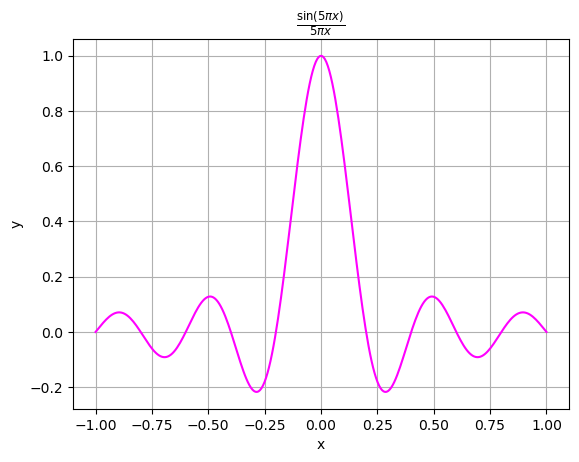

In [31]:
x_values = np.linspace(-1, 1, 300).reshape(-1, 1)
y_values = sinc_function(x_values)
input_tensor, output_tensor = torch.tensor(x_values, dtype=torch.float32), torch.tensor(y_values, dtype=torch.float32)

# Plotting the function
plt.plot(input_tensor, output_tensor, color = "magenta")
plt.title(r'$\frac{\sin(5 \pi x)}{5 \pi x}$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [32]:
"""
    For this task, I have defined a deep learning model with 7 hidden layers using nn.Sequential.
    The model maps a single input feature to a single output, passing through several
    fully connected (linear) layers with ReLU activation functions. Each ReLU activation
    introduces non-linearity, allowing the model to learn complex patterns in the data.
    The architecture follows the pattern:
    
    Input (1) -> 6 -> 12 -> 12 -> 12 -> 12 -> 12 -> 6 -> Output (1)
    
    where each arrow represents a linear layer followed by a ReLU activation, 
    and the numbers indicate the number of units in each layer.
"""

class ModelDNN(nn.Module):
    def __init__(self):
        super(ModelDNN, self).__init__()
        
        # Define layers using nn.Sequential
        self.layers = nn.Sequential(
            nn.Linear(1, 6),   
            nn.ReLU(),         
            
            nn.Linear(6, 12),  
            nn.ReLU(),         
            
            nn.Linear(12, 12), 
            nn.ReLU(),         
            
            nn.Linear(12, 12), 
            nn.ReLU(),         
            
            nn.Linear(12, 12), 
            nn.ReLU(),         
            
            nn.Linear(12, 12), 
            nn.ReLU(),         
            
            nn.Linear(12, 6),  
            nn.ReLU(),         
            
            nn.Linear(6, 1)    
        )

    def forward(self, input_data):
        return self.layers(input_data)


In [33]:
model = ModelDNN()
total_params = sum(p.numel() for p in model.parameters())
print('Total params - ', total_params)


Total params -  805


In [34]:
"""
    This function computes the gradient norm and minimal ratio of positive eigenvalues from the Hessian matrix
    of the given model.

    The function performs the following steps:
    1. Forward Pass: Computes the model outputs and loss using the provided input data (`x_train`) 
       and a custom function to generate target values.
    2. Gradient Norm Calculation: Calculates the norm of the gradients for all model parameters.
    3. Hessian and Eigenvalue Computation: Computes the Hessian matrix for each model parameter 
       and calculates its eigenvalues.
    4. Minimal Ratio Calculation: Determines the proportion of positive eigenvalues from the 
       computed Hessians, representing the "minimal ratio".

"""

def compute_gradient_norm_and_minimal_ratio(model, x_train):
    model.eval()
    outputs = model(x_train)
    loss = criterion(outputs, custom_function(x_train))
    
    optimizer.zero_grad()
    loss.backward()

    gradient_norm = 0
    for param in model.parameters():
        gradient_norm += param.grad.norm().item()
    
    def loss_fn_for_hessian(*params):
        idx = 0
        for param in model.parameters():
            param.data = params[idx].detach().clone().requires_grad_(True)
            idx += 1
        outputs = model(x_train)
        return criterion(outputs, custom_function(x_train))

    params = tuple(param for param in model.parameters())
    
    eigenvalues = []
    for param in params:
        hessian = torch.autograd.functional.hessian(lambda p: loss_fn_for_hessian(*params), (param,))
        
        hessian_matrix = hessian[0][0].detach().numpy()
        
        if hessian_matrix.ndim == 2 and hessian_matrix.shape[0] == hessian_matrix.shape[1]:
            param_eigenvalues = np.linalg.eigvals(hessian_matrix)
            eigenvalues.extend(param_eigenvalues)
        else:
            print(f"Skipping non-square Hessian matrix of shape: {hessian_matrix.shape}")
    
    minimal_ratio = np.sum(np.array(eigenvalues) > 0) / len(eigenvalues) if len(eigenvalues) > 0 else 0
    
    return gradient_norm, minimal_ratio

In [35]:
"""
    Trains the given neural network model using the Adam optimizer and MSE loss function.
    
    The training process consists of:
    1. Forward Pass: Computes model predictions for the given inputs.
    2. Loss Calculation: Measures the difference between predictions and target outputs using Mean Squared Error (MSE).
    3. Backward Pass: Computes gradients of the loss with respect to model parameters.
    4. Parameter Update: Adjusts model parameters based on computed gradients using the Adam optimizer.

    If the gradient norm falls below a specified threshold (0.001) or the maximum number of epochs is reached,
    the function computes the minimal ratio of positive eigenvalues and the loss using the `compute_hessian_ratio` function,
    then terminates training early.

"""


def train_model(model, inputs, outputs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    max_epochs = 5000
    loss_history = []
    gradient_history = []

    for epoch in range(max_epochs):
        model.train()
        predictions = model(inputs)
        loss = criterion(predictions, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        total_gradients = 0.0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm = (param.grad.cpu().data.numpy()**2).sum()
                total_gradients += grad_norm

        total_gradients = total_gradients ** 0.5
        gradient_history.append(total_gradients)

        if total_gradients < 0.001 or epoch == max_epochs - 1:
            print('Gradient norm reached minimum value')

            minimal_ratio, loss_value = compute_hessian_ratio(model, inputs, outputs)
            print(f"Epoch - {epoch} Minimal Ratio - {minimal_ratio}  Loss - {loss_value}")
            break

    return minimal_ratio, loss_value

In [36]:
"""
    This function computes the minimal ratio of positive eigenvalues of the Hessian matrix 
    and the loss value for a given model.

    The function performs the following steps:
    1. Forward Pass: Computes the model predictions and loss using Mean Squared Error (MSE).
    2. Jacobian Calculation: Calculates the first-order derivatives (Jacobian) of the loss 
       with respect to all model parameters.
    3. Hessian Matrix Construction: Computes the second-order derivatives (Hessian) 
       using the previously computed Jacobian for each parameter.
    4. Eigenvalue Analysis: Computes the eigenvalues of the Hessian matrix and determines 
       the proportion of positive eigenvalues, representing the "minimal ratio".
"""

def compute_hessian_ratio(model, x, y):
    criterion = nn.MSELoss()
    total_params = sum(p.numel() for p in model.parameters())

    predictions = model(x)
    loss = criterion(predictions, y)

    # Calculate first order derivatives (Jacobian)
    jacobian = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    jacobian_flattened = torch.cat([j.flatten() for j in jacobian])

    hessian_matrix = torch.zeros((total_params, total_params))

    # Compute second-order derivatives (Hessian)
    for i in range(total_params):
        hessian_elements = torch.autograd.grad(jacobian_flattened[i], model.parameters(), retain_graph=True)
        hessian_matrix[i] = torch.cat([h_elem.flatten() for h_elem in hessian_elements])

    # Compute eigenvalues of the Hessian
    eigenvalues = torch.linalg.eig(hessian_matrix).eigenvalues.real
    positive_eigenvalues = (eigenvalues > 0).sum().item()

    minimal_ratio = positive_eigenvalues / total_params
    return minimal_ratio, loss.item()

In [37]:
loss_values = []
min_ratio_values = []

for run_index in range(100):
    print(f"Training model {run_index}")
    model = ModelDNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    min_ratio, loss_value = train_model(model, input_tensor, input_tensor)
    loss_values.append(loss_value)
    min_ratio_values.append(min_ratio)

Training model 0
Gradient norm reached minimum value
Epoch - 4999 Minimal Ratio - 0.25217391304347825  Loss - 0.07751457393169403
Training model 1
Gradient norm reached minimum value
Epoch - 2819 Minimal Ratio - 0.26956521739130435  Loss - 2.5817242203629576e-05
Training model 2
Gradient norm reached minimum value
Epoch - 4033 Minimal Ratio - 0.21366459627329193  Loss - 2.594763100205455e-05
Training model 3
Gradient norm reached minimum value
Epoch - 4999 Minimal Ratio - 0.2248447204968944  Loss - 2.520096859370824e-05
Training model 4
Gradient norm reached minimum value
Epoch - 4140 Minimal Ratio - 0.284472049689441  Loss - 1.7833146557677537e-05
Training model 5
Gradient norm reached minimum value
Epoch - 4999 Minimal Ratio - 0.26583850931677017  Loss - 0.0012371462071314454
Training model 6
Gradient norm reached minimum value
Epoch - 3907 Minimal Ratio - 0.2708074534161491  Loss - 1.758320831868332e-05
Training model 7
Gradient norm reached minimum value
Epoch - 2447 Minimal Ratio 

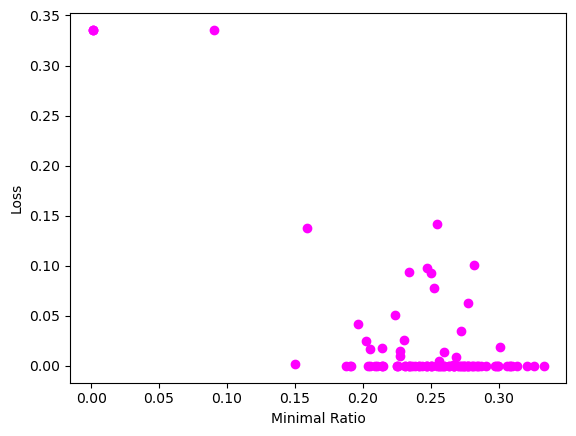

In [44]:
plt.scatter(min_ratio_values, loss_values, color="magenta")
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.show()